In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

plt.style.use('default') # haciendo los graficos un poco mas bonitos en matplotlib
#plt.rcParams['figure.figsize'] = (20, 10)

sns.set(style="whitegrid") # seteando tipo de grid en seaborn

pd.options.display.float_format = '{:20,.2f}'.format # suprimimos la notacion cientifica en los outputs

import warnings
warnings.filterwarnings('ignore')

import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn import tree
from sklearn.preprocessing import OneHotEncoder
!pip install --upgrade scikit-learn
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
id='1Xcx51Afb_Mzw56BCaF0wVu8eGFZWJhcZ'
id2='1F45NhouvIGHdsXLwZ2wU9rZAc16XL8Ls'

downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('train_values.csv')
downloaded2 = drive.CreateFile({'id': id2})
downloaded2.GetContentFile('train_labels.csv')

id3 = "1kKWIYGdPMNp0wv66ZNxAayuWNuh1t7_v"
downloaded3 = drive.CreateFile({'id': id3})
downloaded3.GetContentFile('test_values.csv')
id4 = "1grCPZ3WFSR4T8dRyV8J5CrO_w1psASYT"
downloaded4 = drive.CreateFile({'id': id4})
downloaded4.GetContentFile('submission_format.csv')

#train values
These are the features you'll use to train a model. There are 38 features, including structual information such as the number of floors (before the earthquake), age of the building, and type of foundation, as well as legal information such as ownership status, building use, and the number of families who live there. Each building is identified by a unique (random) building_id, which you can use as an index.

In [ ]:
train_values = pd.read_csv('train_values.csv', encoding='latin1',sep=',', index_col='building_id')
train_values.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
building_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
802906,6,487,12198,2,30,6,5,t,r,n,f,q,t,d,1,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
28830,8,900,2812,2,10,8,7,o,r,n,x,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
94947,21,363,8973,2,10,5,5,t,r,n,f,x,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
590882,22,418,10694,2,10,6,5,t,r,n,f,x,s,d,0,1,0,0,0,0,1,1,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
201944,11,131,1488,3,30,8,9,t,r,n,f,x,s,d,1,0,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0


#train labels
These are the labels. Every building_id in the training values data has a corresponding label in this file. A 1 represents low damage, a 2 represents a medium amount of damage, and a 3 represents almost complete destruction.

In [ ]:
train_labels = pd.read_csv('train_labels.csv', encoding='latin1',sep=',', index_col='building_id')


#test values
These are the features you'll use to make predictions after training a model. We don't give you the labels for these samples, it's up to you to generate predictions of the level of earthquake damage for these building_ids!

In [ ]:
test_values = pd.read_csv('test_values.csv', encoding='latin1',sep=',', index_col='building_id')
test_values

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
building_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
300051,17,596,11307,3,20,7,6,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
99355,6,141,11987,2,25,13,5,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,1,1,0,0,0,0,0,0,0,0,0
890251,22,19,10044,2,5,4,5,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
745817,26,39,633,1,0,19,3,t,r,x,v,j,t,d,0,0,0,0,0,1,0,0,0,0,0,v,2,1,0,0,1,0,0,0,0,0,0,0
421793,17,289,7970,3,15,8,7,t,r,q,f,q,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310028,4,605,3623,3,70,20,6,t,r,q,f,q,t,d,0,1,0,0,0,0,1,0,0,0,0,w,1,1,1,0,0,0,0,0,0,0,0,0
663567,10,1407,11907,3,25,6,7,n,r,n,f,q,s,d,1,1,1,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
1049160,22,1136,7712,1,50,3,3,t,r,n,f,j,s,d,0,1,0,0,0,0,1,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0


#Feature Engeneering


In [ ]:
train_labels.value_counts()

damage_grade
2               148259
3                87218
1                25124
dtype: int64

##.
#.
#.
#.
#.
#.
#.
#.
#.
#.
#.
#.
#.
#.
#.
#.
#.

#features a tener en cuenta


In [ ]:
selected_features = ["geo_level_1_id","geo_level_2_id","geo_level_3_id","count_floors_pre_eq","area_percentage","height_percentage","has_superstructure_adobe_mud",	"has_superstructure_mud_mortar_stone",	"has_superstructure_stone_flag"	,"has_superstructure_cement_mortar_stone"	,"has_superstructure_mud_mortar_brick",	"has_superstructure_cement_mortar_brick",	"has_superstructure_timber",	"has_superstructure_bamboo",	"has_superstructure_rc_non_engineered",	"has_superstructure_rc_engineered"	,"has_superstructure_other"]
train_values_subset = train_values[selected_features]

In [ ]:
train_values_subset = pd.get_dummies(train_values_subset)

#Random Forest del modelo

No tiene sentido aplicar transformaciones qe no cambian el orden de los datos

In [ ]:
# for preprocessing the data
from sklearn.preprocessing import StandardScaler

# the model
from sklearn.ensemble import RandomForestClassifier

# for combining the preprocess with model training
from sklearn.pipeline import make_pipeline

# for optimizing the hyperparameters of the pipeline
from sklearn.model_selection import GridSearchCV

ImportError: ignored

In [ ]:
pipe = make_pipeline(StandardScaler(), 
                     RandomForestClassifier(random_state=2018))
pipe

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=100, n_jobs=None,
                                        oob_score=False, random_state=2018,
                                        verbose=0, warm_start=False))],
         verbose=F

In [ ]:
param_grid = {'randomforestclassifier__n_estimators': [50, 100],
              'randomforestclassifier__min_samples_leaf': [1, 5]}
gs = GridSearchCV(pipe, param_grid, cv=5)

In [ ]:
#le lleva como 10 minutos esto
gs.fit(train_values_subset, train_labels.values.ravel())

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('standardscaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(bootstrap=True,
                                                               ccp_alpha=0.0,
                                                               class_weight=None,
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features='auto',
                                                               max_leaf_nodes=None,
                   

In [ ]:
gs.best_params_

{'randomforestclassifier__min_samples_leaf': 5,
 'randomforestclassifier__n_estimators': 100}

In [ ]:
from sklearn.metrics import f1_score

in_sample_preds = gs.predict(train_values_subset)
f1_score(train_labels, in_sample_preds, average='micro')

0.7715703316564403

#Predicciones


In [ ]:
test_values_subset = test_values[selected_features]
test_values_subset = pd.get_dummies(test_values_subset)


predictions = gs.predict(test_values_subset)

In [ ]:
submission_format = pd.read_csv('submission_format.csv', encoding='latin1',sep=',', index_col='building_id')
my_submission = pd.DataFrame(data=predictions,
                             columns=submission_format.columns,
                             index=submission_format.index)

In [ ]:
my_submission.head()

,damage_grade
building_id,
300051,3
99355,2
890251,2
745817,2
421793,3


In [ ]:
my_submission.to_csv('submission.csv')

In [ ]:
!head submission.csv

building_id,damage_grade
300051,3
99355,2
890251,2
745817,2
421793,3
871976,2
691228,1
896100,3
343471,2


#dio 0,72 en el drivendata

##.
#.
#.
#.
#.
#.
#.
#.
#.
#.
#.
#.
#.
#.
#.
#.
#.

#Igual pero le sumo las que tenian letras con get_dummies o oneHotEncoding
land_surface_condition	foundation_type	roof_type	ground_floor_type	other_floor_type	position	plan_configuration

#features a tener en cuenta (todos salvo usos)

In [ ]:
selected_features = ["geo_level_1_id","geo_level_2_id",	"count_floors_pre_eq"	,"age"	,"area_percentage"	,"height_percentage",	"has_superstructure_adobe_mud"	,"has_superstructure_mud_mortar_stone",	"has_superstructure_stone_flag"	,"has_superstructure_cement_mortar_stone",	"has_superstructure_mud_mortar_brick",	"has_superstructure_cement_mortar_brick",	"has_superstructure_timber"	,"has_superstructure_bamboo"	,"has_superstructure_rc_non_engineered",	"has_superstructure_rc_engineered"	,"has_superstructure_other","land_surface_condition",	"foundation_type",	"roof_type",	"ground_floor_type",	"other_floor_type",	"position"	,"plan_configuration"]
train_values_subset = train_values[selected_features]
train_values_subset["floors/area_p"] = train_values_subset["count_floors_pre_eq"]/train_values_subset["area_percentage"]
train_values_subset["floors/height_p"] = train_values_subset["count_floors_pre_eq"]/train_values_subset["height_percentage"]
train_values_subset = pd.get_dummies(train_values_subset)


#Random Forest del modelo

No tiene sentido aplicar transformaciones qe no cambian el orden de los datos

In [ ]:
# for preprocessing the data
from sklearn.preprocessing import StandardScaler

# the model
from sklearn.ensemble import RandomForestClassifier

# for combining the preprocess with model training
from sklearn.pipeline import make_pipeline

# for optimizing the hyperparameters of the pipeline
from sklearn.model_selection import GridSearchCV


ImportError: ignored

In [ ]:
pipe = make_pipeline(StandardScaler(), 
                     RandomForestClassifier(random_state=2018))
pipe

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=100, n_jobs=None,
                                        oob_score=False, random_state=2018,
                                        verbose=0, warm_start=False))],
         verbose=F

In [ ]:
param_grid = {'randomforestclassifier__n_estimators': [50, 150],
              'randomforestclassifier__min_samples_leaf': [1, 5]}
gs = GridSearchCV(pipe, param_grid, cv=5)

In [ ]:
#le lleva como 14 minutos esto
gs.fit(train_values_subset, train_labels.values.ravel())

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('standardscaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(bootstrap=True,
                                                               ccp_alpha=0.0,
                                                               class_weight=None,
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features='auto',
                                                               max_leaf_nodes=None,
                   

In [ ]:
gs.best_params_

{'randomforestclassifier__min_samples_leaf': 5,
 'randomforestclassifier__n_estimators': 150}

In [ ]:
from sklearn.metrics import f1_score

in_sample_preds = gs.predict(train_values_subset)
f1_score(train_labels, in_sample_preds, average='micro')

0.7540339446126453

In [ ]:
test_values_subset

,geo_level_1_id,geo_level_2_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,land_surface_condition_n,land_surface_condition_o,land_surface_condition_t,foundation_type_h,foundation_type_i,foundation_type_r,foundation_type_u,foundation_type_w,roof_type_n,roof_type_q,roof_type_x,ground_floor_type_f,ground_floor_type_m,ground_floor_type_v,ground_floor_type_x,ground_floor_type_z,other_floor_type_j,other_floor_type_q,other_floor_type_s,other_floor_type_x,position_j,position_o,position_s,position_t,plan_configuration_a,plan_configuration_c,plan_configuration_d,plan_configuration_f,plan_configuration_m,plan_configuration_n,plan_configuration_o,plan_configuration_q,plan_configuration_s,plan_configuration_u
building_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
300051,17,596,3,20,7,6,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
99355,6,141,2,25,13,5,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
890251,22,19,2,5,4,5,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
745817,26,39,1,0,19,3,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0
421793,17,289,3,15,8,7,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310028,4,605,3,70,20,6,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0
663567,10,1407,3,25,6,7,1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
1049160,22,1136,1,50,3,3,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0


#predicciones

In [ ]:
selected_features = ["geo_level_1_id","geo_level_2_id",	"count_floors_pre_eq"	,"age"	,"area_percentage"	,"height_percentage",	"has_superstructure_adobe_mud"	,"has_superstructure_mud_mortar_stone",	"has_superstructure_stone_flag"	,"has_superstructure_cement_mortar_stone",	"has_superstructure_mud_mortar_brick",	"has_superstructure_cement_mortar_brick",	"has_superstructure_timber"	,"has_superstructure_bamboo"	,"has_superstructure_rc_non_engineered",	"has_superstructure_rc_engineered"	,"has_superstructure_other","land_surface_condition",	"foundation_type",	"roof_type",	"ground_floor_type",	"other_floor_type",	"position"	,"plan_configuration"]
test_values_subset = test_values[selected_features]
test_values_subset["floors/area_p"] = test_values_subset["count_floors_pre_eq"]/test_values_subset["area_percentage"]
test_values_subset["floors/height_p"] = test_values_subset["count_floors_pre_eq"]/test_values_subset["height_percentage"]
test_values_subset = pd.get_dummies(test_values_subset)


predictions = gs.predict(test_values_subset)

In [ ]:
submission_format = pd.read_csv('submission_format.csv', encoding='latin1',sep=',', index_col='building_id')
my_submission = pd.DataFrame(data=predictions,
                             columns=submission_format.columns,
                             index=submission_format.index)

In [ ]:
my_submission.head()

,damage_grade
building_id,
300051,3
99355,2
890251,2
745817,1
421793,3


In [ ]:
my_submission.to_csv('submission.csv')

In [ ]:
!head submission.csv

building_id,damage_grade
300051,3
99355,2
890251,2
745817,1
421793,3
871976,3
691228,1
896100,3
343471,2


#0.71 en driven data, debe ser overfitting. f1 dio casi 1 además

#En el proximo habria que empezar a jugar con la interaccion entre features (lo que hicimos en el tp1), es importante en arboles porque no tienen en cuenta esto. Splitean por columna de manera aislada

In [ ]:
forest = RandomForestClassifier(random_state = 123, n_estimators = 100, min_samples_leaf = 1)
X=train_values_subset
y=train_labels.values.ravel()
forest.fit(X,y)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=123,
                       verbose=0, warm_start=False)

In [ ]:
#es lo mismo que arriba, pero es para ver los features
from sklearn.metrics import f1_score

in_sample_preds = forest.predict(train_values_subset)
f1_score(train_labels, in_sample_preds, average='micro')

0.9842824854854739

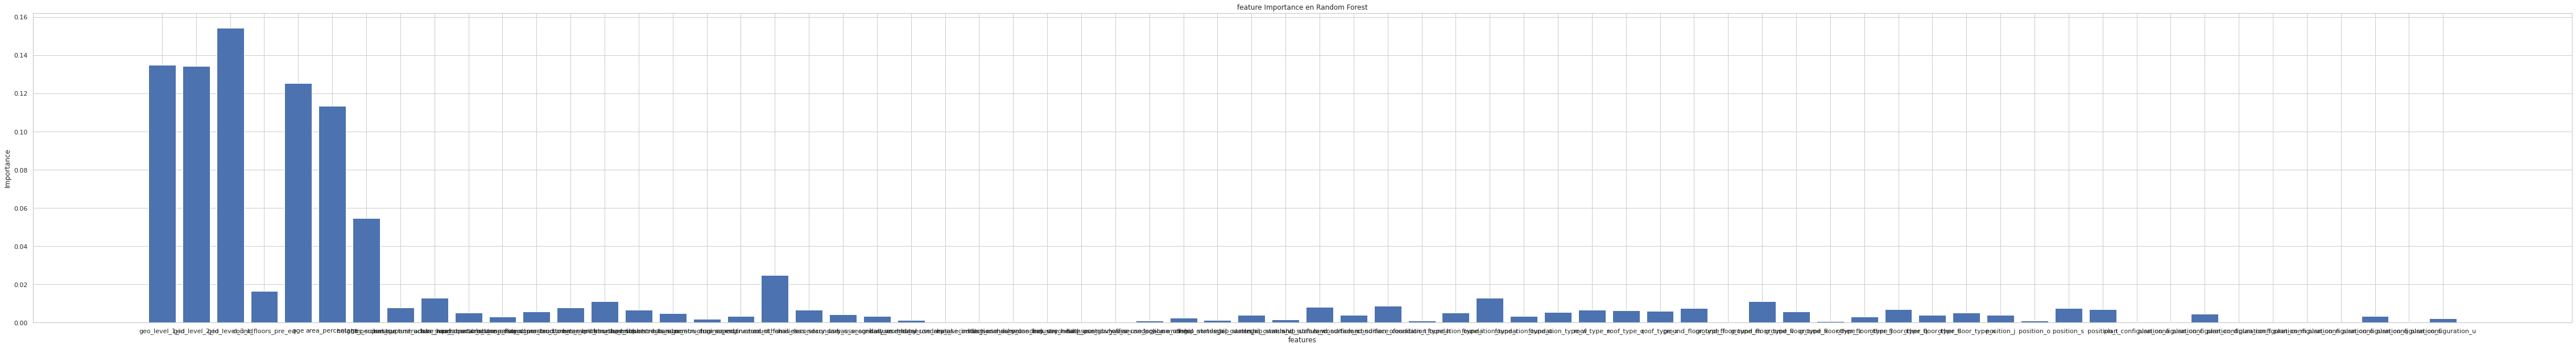

In [ ]:
#mas importantes geo1 geo2 geo3 age(no filtre los casos raros) area_percentage height_percentage has_superstructure_adobe_mud
plt.bar(train_values_subset.columns,forest.feature_importances_)
plt.xlabel("features")
plt.ylabel("Importance")
plt.title("feature Importance en Random Forest")
plt.rcParams["figure.figsize"] = (80,30)
plt.show()

#habria que probar balanceando la cantidad de edificios con daño 1,2 y 3

##.
#.
#.
#.
#.
#.
#.
#.
#.
#.
#.
#.
#.
#.
#.
#.
#.

#XGBoost

In [ ]:
#instancio el regresor
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

xgb_reg = xgb.XGBClassifier(objetive="binary:logistic",seed = 123)

ImportError: ignored

#45 min

HalvingGridSearchCV(cv=3,

                    estimator=XGBClassifier(objetive='binary:logistic',

                                            seed=123),

                    n_jobs=-1,

                    param_grid={'base_score': [0.5],

                                'colsample_bytree': [0.4, 0.6],

                                'learning_rate': [0.1, 0.2],

                                'max_delta_step': [0], 'max_depth': [4, 7, 9],

                                'n_estimators': [100, 200],

                                'subsample': [0.7, 0.8]},

                    refit=<function _refit_callable at 0x7f68b05b4440>,

                    scoring='f1_micro')


  #best: {'base_score': 0.5,
 #'colsample_bytree': 0.6,
 #'learning_rate': 0.1,
 #'max_delta_step': 0,
 #'max_depth': 9,
 #'n_estimators': 100,
 #'subsample': 0.8}
 #0.7281134283686038, 0.7267 en drivendata

XGB

{'base_score': 0.5,
 'colsample_bytree': 0.6,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 13,
 'n_estimators': 100,
 'subsample': 0.8}  llevo 1:53


 quedaron {'base_score': 0.5,
 'colsample_bytree': 0.6,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 13,
 'n_estimators': 100,
 'subsample': 0.8}

 cv = 5


 F1:  0.7408722012240747
 drivenData: 0.7396

In [ ]:

parameters =    {
            'max_depth': [9, 13],
            'learning_rate': [0.1, 0.2],
            'n_estimators': [100,150],
            'max_delta_step': [0],
            'subsample': [ 0.8,0.9],
            'colsample_bytree': [ 0.6,0.7],
            'base_score': [0.5],
            }




#parameters =    {
#            'max_depth': [3, 4, 5,7,9],
#            'learning_rate': [0.1, 0.2, 0.3, 0.4],
#            'n_estimators': [50, 100, 150, 200],
#            'gamma': [0, 0.1, 0.2],
#            'min_child_weight': [0, 0.5, 1],
#            'max_delta_step': [0],
#            'subsample': [0.7, 0.8, 0.9, 1],
#            'colsample_bytree': [0.4, 0.6, 0.8, 1],
#            'colsample_bylevel': [1],
#            'reg_alpha': [0, 1e-2, 1, 1e1, 10],
#            'reg_lambda': [0, 1e-2, 1, 1e1],
#            'base_score': [0.5],
#
#            }

In [ ]:
HGS = HalvingGridSearchCV(xgb_reg, parameters, scoring = 'f1_micro', n_jobs=-1, cv=5)

In [ ]:
selected_features = ["geo_level_1_id","geo_level_2_id","geo_level_3_id",	"count_floors_pre_eq"	,"age"	,"area_percentage"	,"height_percentage",	"has_superstructure_adobe_mud"	,"has_superstructure_mud_mortar_stone",	"has_superstructure_stone_flag"	,"has_superstructure_cement_mortar_stone",	"has_superstructure_mud_mortar_brick",	"has_superstructure_cement_mortar_brick",	"has_superstructure_timber"	,"has_superstructure_bamboo"	,"has_superstructure_rc_non_engineered",	"has_superstructure_rc_engineered"	,"has_superstructure_other","land_surface_condition",	"foundation_type",	"roof_type",	"ground_floor_type",	"other_floor_type",	"position"	,"plan_configuration"]
train_values_subset = train_values[selected_features]
train_values_subset["floors/area_p"] = train_values_subset["count_floors_pre_eq"]/train_values_subset["area_percentage"]
train_values_subset["floors/height_p"] = train_values_subset["count_floors_pre_eq"]/train_values_subset["height_percentage"]
train_values_subset["no_secondary_use"] = 1 if  train_values_subset["has_secondary_use"] == 0 else 0
train_values_subset = pd.get_dummies(train_values_subset)


KeyError: ignored

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(train_values_subset,train_labels,test_size=0.2,train_size=0.8)

#entreno

In [ ]:
HGS.fit(X_train,y_train)

HalvingGridSearchCV(estimator=XGBClassifier(objetive='binary:logistic',
                                            seed=123),
                    n_jobs=-1,
                    param_grid={'base_score': [0.5],
                                'colsample_bytree': [0.6, 0.7],
                                'learning_rate': [0.1, 0.2],
                                'max_delta_step': [0], 'max_depth': [9, 13],
                                'n_estimators': [100, 150],
                                'subsample': [0.8, 0.9]},
                    refit=<function _refit_callable at 0x7f68b05b4440>,
                    scoring='f1_micro')

In [ ]:
HGS.best_params_

{'base_score': 0.5,
 'colsample_bytree': 0.6,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 13,
 'n_estimators': 100,
 'subsample': 0.8}

In [ ]:
preds = HGS.predict(X_test)

#error f1

In [ ]:
from sklearn.metrics import f1_score


f1_score(y_test, preds, average='micro')

0.7408722012240747

#prediccion

In [ ]:
test_values_subset = test_values[selected_features]
test_values_subset["floors/area_p"] = test_values_subset["count_floors_pre_eq"]/test_values_subset["area_percentage"]
test_values_subset["floors/height_p"] = test_values_subset["count_floors_pre_eq"]/test_values_subset["height_percentage"]
test_values_subset = pd.get_dummies(test_values_subset)


predictions = HGS.predict(test_values_subset)

In [ ]:
submission_format = pd.read_csv('submission_format.csv', encoding='latin1',sep=',', index_col='building_id')
my_submission = pd.DataFrame(data=predictions,
                             columns=submission_format.columns,
                             index=submission_format.index)

In [ ]:
my_submission.head()

,damage_grade
building_id,
300051,3
99355,2
890251,2
745817,2
421793,3


In [ ]:
my_submission.to_csv('submission.csv')
!head submission.csv

building_id,damage_grade
300051,3
99355,2
890251,2
745817,2
421793,3
871976,2
691228,1
896100,3
343471,2


#XGB cronologicamente posterior a anteriores


In [ ]:
#instancio el regresor
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

xgb_reg = xgb.XGBClassifier(objetive="multi:softprob",seed = 123)

In [ ]:
parameters = {'base_score':[0.5] ,
 'colsample_bytree': [0.6],
 'learning_rate': [0.1],
 'max_delta_step': [1],
 'max_depth': [13],
 'n_estimators': [150],
 'subsample': [0.8]}



In [ ]:
HGS = HalvingGridSearchCV(xgb_reg, parameters, scoring = 'f1_micro', n_jobs=-1, cv=5)

columna uses arbol


In [ ]:
xgb_clas_use = xgb.XGBClassifier(objetive="multi:softprob",seed = 123)

parameters_xgb_clas_use = {'base_score':[0.5] ,
 'colsample_bytree': [0.6],
 'learning_rate': [0.1],
 'max_delta_step': [1],
 'max_depth': [25],
 'n_estimators': [60],
 'subsample': [0.2]}

HGS_xgb_clas_use = HalvingGridSearchCV(xgb_clas_use, parameters_xgb_clas_use, scoring = 'f1_micro', n_jobs=-1, cv=5)

selected_features_xgb_clas_use = ["has_secondary_use_agriculture"	,"has_secondary_use_hotel",	"has_secondary_use_rental",	"has_secondary_use_institution"	,"has_secondary_use_school",	"has_secondary_use_industry"	,"has_secondary_use_health_post"	,"has_secondary_use_gov_office",	"has_secondary_use_use_police"	,"has_secondary_use_other"]
train_values_subset_xgb_clas_use = train_values[selected_features_xgb_clas_use]

from sklearn.model_selection import train_test_split
X_train_u,X_test_u,y_train_u,y_test_u = train_test_split(train_values_subset_xgb_clas_use,train_labels,test_size=0.2,train_size=0.8)

HGS_xgb_clas_use.fit(X_train_u,y_train_u)

HalvingGridSearchCV(estimator=XGBClassifier(objetive='multi:softprob',
                                            seed=123),
                    n_jobs=-1,
                    param_grid={'base_score': [0.5], 'colsample_bytree': [0.6],
                                'learning_rate': [0.1], 'max_delta_step': [1],
                                'max_depth': [25], 'n_estimators': [60],
                                'subsample': [0.2]},
                    refit=<function _refit_callable at 0x7f504ae5d5f0>,
                    scoring='f1_micro')

In [ ]:
HGS_xgb_clas_use.best_params_

{'base_score': 0.5,
 'colsample_bytree': 0.6,
 'learning_rate': 0.1,
 'max_delta_step': 1,
 'max_depth': 25,
 'n_estimators': 60,
 'subsample': 0.2}

In [ ]:
preds_xgb_clas_use = HGS_xgb_clas_use.predict(X_test_u)
from sklearn.metrics import f1_score




f1_score(y_test_u, preds_xgb_clas_use, average='micro')

0.5671418430191285

fin col uses arbol


Columna testeando geoLevel arbol


In [ ]:
#instancio el clasificador


xgb_clas = xgb.XGBClassifier(objetive="multi:softprob",seed = 123)

parameters_xgb_clas = {'base_score':[0.5] ,
 'colsample_bytree': [0.6],
 'learning_rate': [0.1],
 'max_delta_step': [1],
 'max_depth': [13],
 'n_estimators': [300],
 'subsample': [0.2]}

HGS_xgb_clas = HalvingGridSearchCV(xgb_clas, parameters_xgb_clas, scoring = 'f1_micro', n_jobs=-1, cv=5)

selected_features_xgb_clas = ["geo_level_1_id","geo_level_2_id","geo_level_3_id"]
train_values_subset_xgb_clas = train_values[selected_features_xgb_clas]

from sklearn.model_selection import train_test_split
X_train_,X_test_,y_train_,y_test_ = train_test_split(train_values_subset_xgb_clas,train_labels,test_size=0.2,train_size=0.8)

HGS_xgb_clas.fit(X_train_,y_train_)

HalvingGridSearchCV(estimator=XGBClassifier(objetive='multi:softprob',
                                            seed=123),
                    n_jobs=-1,
                    param_grid={'base_score': [0.5], 'colsample_bytree': [0.6],
                                'learning_rate': [0.1], 'max_delta_step': [1],
                                'max_depth': [13], 'n_estimators': [300],
                                'subsample': [0.2]},
                    refit=<function _refit_callable at 0x7f504ae5d5f0>,
                    scoring='f1_micro')

In [ ]:
HGS_xgb_clas.best_params_

{'base_score': 0.5,
 'colsample_bytree': 0.6,
 'learning_rate': 0.1,
 'max_delta_step': 1,
 'max_depth': 13,
 'n_estimators': 300,
 'subsample': 0.2}

In [ ]:
preds_xgb_clas = HGS_xgb_clas.predict(X_test_)
from sklearn.metrics import f1_score


f1_score(y_test_, preds_xgb_clas, average='micro')

0.7142610464112354

In [ ]:
preds_xgb_clas

array([3, 2, 3, ..., 3, 2, 2])

Fin geoLevelColumna


In [ ]:
from scipy.stats.mstats import winsorize

selected_features = ["geo_level_1_id","geo_level_2_id","geo_level_3_id",	"count_floors_pre_eq"	,"age"	,"area_percentage"	,"height_percentage",	"has_superstructure_adobe_mud"	,"has_superstructure_mud_mortar_stone",	"has_superstructure_stone_flag"	,"has_superstructure_cement_mortar_stone",	"has_superstructure_mud_mortar_brick",	"has_superstructure_cement_mortar_brick",	"has_superstructure_timber"	,"has_superstructure_bamboo"	,"has_superstructure_rc_non_engineered",	"has_superstructure_rc_engineered"	,"has_superstructure_other","land_surface_condition",	"foundation_type",	"roof_type",	"ground_floor_type",	"other_floor_type",	"position"	,"plan_configuration","has_secondary_use",	"has_secondary_use_agriculture"	,"has_secondary_use_hotel",	"has_secondary_use_rental",	"has_secondary_use_institution"	,"has_secondary_use_school",	"has_secondary_use_industry"	,"has_secondary_use_health_post"	,"has_secondary_use_gov_office",	"has_secondary_use_use_police"	,"has_secondary_use_other"]

#selected_features = ["count_floors_pre_eq"	,"age"	,"area_percentage"	,"height_percentage",	"has_superstructure_adobe_mud"	,"has_superstructure_mud_mortar_stone",	"has_superstructure_stone_flag"	,"has_superstructure_cement_mortar_stone",	"has_superstructure_mud_mortar_brick",	"has_superstructure_cement_mortar_brick",	"has_superstructure_timber"	,"has_superstructure_bamboo"	,"has_superstructure_rc_non_engineered",	"has_superstructure_rc_engineered"	,"has_superstructure_other","land_surface_condition",	"foundation_type",	"roof_type",	"ground_floor_type",	"other_floor_type",	"position"	,"plan_configuration"]
train_values_subset = train_values[selected_features]


train_values_subset["damage_use"]= HGS_xgb_clas_use.predict(train_values_subset_xgb_clas_use)
train_values_subset["damage_geo_level"] = HGS_xgb_clas.predict(train_values[["geo_level_1_id","geo_level_2_id","geo_level_3_id"]])







train_values_subset["age"] = winsorize(train_values_subset["age"],(0, 0.05))
train_values_subset["area_percentage"] = winsorize(train_values_subset["area_percentage"],(0, 0.05))
train_values_subset["height_percentage"] = winsorize(train_values_subset["height_percentage"],(0, 0.05))



train_values_subset["floors/area_p"] = train_values_subset["count_floors_pre_eq"]/train_values_subset["area_percentage"]
train_values_subset["floors/height_p"] = train_values_subset["count_floors_pre_eq"]/train_values_subset["height_percentage"]
train_values_subset["height_p/area_p"] = train_values_subset["height_percentage"]/train_values_subset["area_percentage"]
train_values_subset["doesnt_have_secondary_use"] = 1-train_values_subset["has_secondary_use"]
del train_values_subset["has_secondary_use"]
train_values_subset["has_secondary_use_other"]  = train_values_subset["has_secondary_use_other"]  |  train_values_subset["has_secondary_use_rental"] |  train_values_subset["has_secondary_use_use_police"] |  train_values_subset["has_secondary_use_institution"]|  train_values_subset["has_secondary_use_school"]|  train_values_subset["has_secondary_use_industry"]|  train_values_subset["has_secondary_use_health_post"]|  train_values_subset["has_secondary_use_gov_office"]
del train_values_subset["has_secondary_use_rental"]
del train_values_subset["has_secondary_use_institution"]
del train_values_subset["has_secondary_use_industry"]
del train_values_subset["has_secondary_use_health_post"]
del train_values_subset["has_secondary_use_gov_office"]
del train_values_subset["has_secondary_use_use_police"]
del train_values_subset["has_secondary_use_school"]




train_values_subset = pd.get_dummies(train_values_subset)
train_values_subset.head()





#0.7434623280443583 el f1 0.7411 en driven data (con multisoft prob dio 7416 en drivendata)
#selected_features = ["geo_level_1_id","geo_level_2_id","geo_level_3_id",	"count_floors_pre_eq"	,"age"	,"area_percentage"	,"height_percentage",	"has_superstructure_adobe_mud"	,"has_superstructure_mud_mortar_stone",	"has_superstructure_stone_flag"	,"has_superstructure_cement_mortar_stone",	"has_superstructure_mud_mortar_brick",	"has_superstructure_cement_mortar_brick",	"has_superstructure_timber"	,"has_superstructure_bamboo"	,"has_superstructure_rc_non_engineered",	"has_superstructure_rc_engineered"	,"has_superstructure_other","land_surface_condition",	"foundation_type",	"roof_type",	"ground_floor_type",	"other_floor_type",	"position"	,"plan_configuration","has_secondary_use",	"has_secondary_use_agriculture"	,"has_secondary_use_hotel",	"has_secondary_use_rental",	"has_secondary_use_institution"	,"has_secondary_use_school",	"has_secondary_use_industry"	,"has_secondary_use_health_post"	,"has_secondary_use_gov_office",	"has_secondary_use_use_police"	,"has_secondary_use_other"]
#train_values_subset = train_values[selected_features]
#train_values_subset["floors/area_p"] = train_values_subset["count_floors_pre_eq"]/train_values_subset["area_percentage"]
#train_values_subset["floors/height_p"] = train_values_subset["count_floors_pre_eq"]/train_values_subset["height_percentage"]
#train_values_subset["height_p/area_p"] = train_values_subset["height_percentage"]/train_values_subset["area_percentage"]
#train_values_subset["doesnt_have_secondary_use"] = 1-train_values_subset["has_secondary_use"]
#del train_values_subset["has_secondary_use"]
#train_values_subset["has_secondary_use_other"]  = train_values_subset["has_secondary_use_other"]  |  train_values_subset["has_secondary_use_rental"] |  train_values_subset["has_secondary_use_use_police"] |  train_values_subset["has_secondary_use_institution"]|  train_values_subset["has_secondary_use_school"]|  train_values_subset["has_secondary_use_industry"]|  train_values_subset["has_secondary_use_health_post"]|  train_values_subset["has_secondary_use_gov_office"]
#del train_values_subset["has_secondary_use_rental"]
#del train_values_subset["has_secondary_use_institution"]
#del train_values_subset["has_secondary_use_industry"]
#del train_values_subset["has_secondary_use_health_post"]
#del train_values_subset["has_secondary_use_gov_office"]
#del train_values_subset["has_secondary_use_use_police"]
#el train_values_subset["has_secondary_use_school"]
#train_values_subset = pd.get_dummies(train_values_subset)
#train_values_subset.head()

#con lo de abajo dio 0.7431553500508432 f1 y en driven data 0.7417
#selected_features = ["geo_level_1_id","geo_level_2_id","geo_level_3_id",	"count_floors_pre_eq"	,"age"	,"area_percentage"	,"height_percentage",	"has_superstructure_adobe_mud"	,"has_superstructure_mud_mortar_stone",	"has_superstructure_stone_flag"	,"has_superstructure_cement_mortar_stone",	"has_superstructure_mud_mortar_brick",	"has_superstructure_cement_mortar_brick",	"has_superstructure_timber"	,"has_superstructure_bamboo"	,"has_superstructure_rc_non_engineered",	"has_superstructure_rc_engineered"	,"has_superstructure_other","land_surface_condition",	"foundation_type",	"roof_type",	"ground_floor_type",	"other_floor_type",	"position"	,"plan_configuration","has_secondary_use",	"has_secondary_use_agriculture"	,"has_secondary_use_hotel",	"has_secondary_use_rental",	"has_secondary_use_institution"	,"has_secondary_use_school",	"has_secondary_use_industry"	,"has_secondary_use_health_post"	,"has_secondary_use_gov_office",	"has_secondary_use_use_police"	,"has_secondary_use_other"]
#train_values_subset = train_values[selected_features]
#train_values_subset["floors/area_p"] = train_values_subset["count_floors_pre_eq"]/train_values_subset["area_percentage"]
#train_values_subset["floors/height_p"] = train_values_subset["count_floors_pre_eq"]/train_values_subset["height_percentage"]

#train_values_subset["doesnt_have_secondary_use"] = 1-train_values_subset["has_secondary_use"]
#del train_values_subset["has_secondary_use"]
#train_values_subset["has_secondary_use_other"]  = train_values_subset["has_secondary_use_other"]  |  train_values_subset["has_secondary_use_rental"] |  train_values_subset["has_secondary_use_use_police"] |  train_values_subset["has_secondary_use_institution"]|  train_values_subset["has_secondary_use_school"]|  train_values_subset["has_secondary_use_industry"]|  train_values_subset["has_secondary_use_health_post"]|  train_values_subset["has_secondary_use_gov_office"]
#del train_values_subset["has_secondary_use_rental"]
#del train_values_subset["has_secondary_use_institution"]
#del train_values_subset["has_secondary_use_industry"]
#del train_values_subset["has_secondary_use_health_post"]
#del train_values_subset["has_secondary_use_gov_office"]
##del train_values_subset["has_secondary_use_use_police"]
#del train_values_subset["has_secondary_use_school"]
#train_values_subset = pd.get_dummies(train_values_subset)
#train_values_subset.head()


,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_other,damage_use,damage_geo_level,floors/area_p,floors/height_p,height_p/area_p,doesnt_have_secondary_use,land_surface_condition_n,land_surface_condition_o,land_surface_condition_t,foundation_type_h,foundation_type_i,foundation_type_r,foundation_type_u,foundation_type_w,roof_type_n,roof_type_q,roof_type_x,ground_floor_type_f,ground_floor_type_m,ground_floor_type_v,ground_floor_type_x,ground_floor_type_z,other_floor_type_j,other_floor_type_q,other_floor_type_s,other_floor_type_x,position_j,position_o,position_s,position_t,plan_configuration_a,plan_configuration_c,plan_configuration_d,plan_configuration_f,plan_configuration_m,plan_configuration_n,plan_configuration_o,plan_configuration_q,plan_configuration_s,plan_configuration_u
building_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
802906,6,487,12198,2,30,6,5,1,1,0,0,0,0,0,0,0,0,0,0,0,0,2,3,0.33,0.40,0.83,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0
28830,8,900,2812,2,10,8,7,0,1,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.25,0.29,0.88,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
94947,21,363,8973,2,10,5,5,0,1,0,0,0,0,0,0,0,0,0,0,0,0,2,3,0.40,0.40,1.00,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0
590882,22,418,10694,2,10,6,5,0,1,0,0,0,0,1,1,0,0,0,0,0,0,2,2,0.33,0.40,0.83,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0
201944,11,131,1488,3,30,8,9,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.38,0.33,1.12,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0


In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(train_values_subset,train_labels,test_size=0.2,train_size=0.8)

In [ ]:
HGS.fit(X_train,y_train)

HalvingGridSearchCV(estimator=XGBClassifier(objetive='multi:softprob',
                                            seed=123),
                    n_jobs=-1,
                    param_grid={'base_score': [0.5], 'colsample_bytree': [0.6],
                                'learning_rate': [0.1], 'max_delta_step': [1],
                                'max_depth': [13], 'n_estimators': [150],
                                'subsample': [0.8]},
                    refit=<function _refit_callable at 0x7f504ae5d5f0>,
                    scoring='f1_micro')

In [ ]:
HGS.best_params_

{'base_score': 0.5,
 'colsample_bytree': 0.6,
 'learning_rate': 0.1,
 'max_delta_step': 1,
 'max_depth': 13,
 'n_estimators': 150,
 'subsample': 0.8}

In [ ]:
preds = HGS.predict(X_test)

In [ ]:
from sklearn.metrics import f1_score


f1_score(y_test, preds, average='micro')


0.7474722280846492

In [ ]:

test_values_subset = test_values[selected_features]
test_uses = test_values[["has_secondary_use_agriculture"	,"has_secondary_use_hotel",	"has_secondary_use_rental",	"has_secondary_use_institution"	,"has_secondary_use_school",	"has_secondary_use_industry"	,"has_secondary_use_health_post"	,"has_secondary_use_gov_office",	"has_secondary_use_use_police"	,"has_secondary_use_other"]]

test_values_subset["damage_use"]= HGS_xgb_clas_use.predict(test_uses)
test_values_subset["damage_geo_level"] = HGS_xgb_clas.predict(test_values[["geo_level_1_id","geo_level_2_id","geo_level_3_id"]])




test_values_subset["age"] = winsorize(test_values_subset["age"],(0, 0.05))
test_values_subset["area_percentage"] = winsorize(test_values_subset["area_percentage"],(0, 0.055))
test_values_subset["height_percentage"] = winsorize(test_values_subset["height_percentage"],(0, 0.04))


test_values_subset["floors/area_p"] = test_values_subset["count_floors_pre_eq"]/test_values_subset["area_percentage"]
test_values_subset["floors/height_p"] = test_values_subset["count_floors_pre_eq"]/test_values_subset["height_percentage"]
test_values_subset["height_p/area_p"] = test_values_subset["height_percentage"]/test_values_subset["area_percentage"]


test_values_subset["doesnt_have_secondary_use"] = 1-test_values_subset["has_secondary_use"]
del test_values_subset["has_secondary_use"]
test_values_subset["has_secondary_use_other"]  = test_values_subset["has_secondary_use_other"]  |  test_values_subset["has_secondary_use_rental"] |  test_values_subset["has_secondary_use_use_police"] |  test_values_subset["has_secondary_use_institution"]|  test_values_subset["has_secondary_use_school"]|  test_values_subset["has_secondary_use_industry"]|  test_values_subset["has_secondary_use_health_post"]|  test_values_subset["has_secondary_use_gov_office"]
del test_values_subset["has_secondary_use_rental"]
del test_values_subset["has_secondary_use_institution"]
del test_values_subset["has_secondary_use_industry"]
del test_values_subset["has_secondary_use_health_post"]
del test_values_subset["has_secondary_use_gov_office"]
del test_values_subset["has_secondary_use_use_police"]
del test_values_subset["has_secondary_use_school"]

test_values_subset = pd.get_dummies(test_values_subset)


predictions = HGS.predict(test_values_subset)

In [ ]:
submission_format = pd.read_csv('submission_format.csv', encoding='latin1',sep=',', index_col='building_id')
my_submission = pd.DataFrame(data=predictions,
                             columns=submission_format.columns,
                             index=submission_format.index)

In [ ]:
my_submission.head()

,damage_grade
building_id,
300051,3
99355,2
890251,2
745817,1
421793,3


In [ ]:
my_submission.to_csv('submission.csv')
!head submission.csv

building_id,damage_grade
300051,3
99355,2
890251,2
745817,1
421793,3
871976,2
691228,1
896100,3
343471,2


In [ ]:
from google.colab import files
files.download("submission.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#XGB Softmax Sin geo id, F1 baja a 0.61



In [ ]:
#instancio el regresor
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

xgb_reg = xgb.XGBClassifier(objetive="multi:softmax",seed = 123)

In [ ]:
parameters = {'base_score':[0.5] ,
 'colsample_bytree': [0.6],
 'learning_rate': [0.1],
 'max_delta_step': [1],
 'max_depth': [13,20,25],
 'n_estimators': [120],
 'subsample': [0.8]}



In [ ]:
HGS = HalvingGridSearchCV(xgb_reg, parameters, scoring = 'f1_micro', n_jobs=-1, cv=5)

In [ ]:
from scipy.stats.mstats import winsorize

selected_features = [	"count_floors_pre_eq"	,"age"	,"area_percentage"	,"height_percentage",	"has_superstructure_adobe_mud"	,"has_superstructure_mud_mortar_stone",	"has_superstructure_stone_flag"	,"has_superstructure_cement_mortar_stone",	"has_superstructure_mud_mortar_brick",	"has_superstructure_cement_mortar_brick",	"has_superstructure_timber"	,"has_superstructure_bamboo"	,"has_superstructure_rc_non_engineered",	"has_superstructure_rc_engineered"	,"has_superstructure_other","land_surface_condition",	"foundation_type",	"roof_type",	"ground_floor_type",	"other_floor_type",	"position"	,"plan_configuration","has_secondary_use",	"has_secondary_use_agriculture"	,"has_secondary_use_hotel",	"has_secondary_use_rental",	"has_secondary_use_institution"	,"has_secondary_use_school",	"has_secondary_use_industry"	,"has_secondary_use_health_post"	,"has_secondary_use_gov_office",	"has_secondary_use_use_police"	,"has_secondary_use_other"]
train_values_subset = train_values[selected_features]

train_values_subset["age"] = winsorize(train_values_subset["age"],(0, 0.05))
train_values_subset["area_percentage"] = winsorize(train_values_subset["area_percentage"],(0, 0.055))
train_values_subset["height_percentage"] = winsorize(train_values_subset["height_percentage"],(0, 0.04))



train_values_subset["floors/area_p"] = train_values_subset["count_floors_pre_eq"]/train_values_subset["area_percentage"]
train_values_subset["floors/height_p"] = train_values_subset["count_floors_pre_eq"]/train_values_subset["height_percentage"]
train_values_subset["height_p/area_p"] = train_values_subset["height_percentage"]/train_values_subset["area_percentage"]
train_values_subset["doesnt_have_secondary_use"] = 1-train_values_subset["has_secondary_use"]
del train_values_subset["has_secondary_use"]
train_values_subset["has_secondary_use_other"]  = train_values_subset["has_secondary_use_other"]  |  train_values_subset["has_secondary_use_rental"] |  train_values_subset["has_secondary_use_use_police"] |  train_values_subset["has_secondary_use_institution"]|  train_values_subset["has_secondary_use_school"]|  train_values_subset["has_secondary_use_industry"]|  train_values_subset["has_secondary_use_health_post"]|  train_values_subset["has_secondary_use_gov_office"]
del train_values_subset["has_secondary_use_rental"]
del train_values_subset["has_secondary_use_institution"]
del train_values_subset["has_secondary_use_industry"]
del train_values_subset["has_secondary_use_health_post"]
del train_values_subset["has_secondary_use_gov_office"]
del train_values_subset["has_secondary_use_use_police"]
del train_values_subset["has_secondary_use_school"]

train_values_subset = pd.get_dummies(train_values_subset)
train_values_subset.head()



,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_other,floors/area_p,floors/height_p,height_p/area_p,doesnt_have_secondary_use,land_surface_condition_n,land_surface_condition_o,land_surface_condition_t,foundation_type_h,foundation_type_i,foundation_type_r,foundation_type_u,foundation_type_w,roof_type_n,roof_type_q,roof_type_x,ground_floor_type_f,ground_floor_type_m,ground_floor_type_v,ground_floor_type_x,ground_floor_type_z,other_floor_type_j,other_floor_type_q,other_floor_type_s,other_floor_type_x,position_j,position_o,position_s,position_t,plan_configuration_a,plan_configuration_c,plan_configuration_d,plan_configuration_f,plan_configuration_m,plan_configuration_n,plan_configuration_o,plan_configuration_q,plan_configuration_s,plan_configuration_u
building_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
802906,2,30,6,5,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0.33,0.40,0.83,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0
28830,2,10,8,7,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0.25,0.29,0.88,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
94947,2,10,5,5,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0.40,0.40,1.00,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0
590882,2,10,6,5,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0.33,0.40,0.83,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0
201944,3,30,8,9,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.38,0.33,1.12,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0


In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(train_values_subset,train_labels,test_size=0.2,train_size=0.8)

In [ ]:
HGS.fit(X_train,y_train)

HalvingGridSearchCV(estimator=XGBClassifier(objetive='multi:softmax', seed=123),
                    n_jobs=-1,
                    param_grid={'base_score': [0.5], 'colsample_bytree': [0.6],
                                'learning_rate': [0.1], 'max_delta_step': [1],
                                'max_depth': [13, 20, 25],
                                'n_estimators': [120], 'subsample': [0.8]},
                    refit=<function _refit_callable at 0x7fa795e70d40>,
                    scoring='f1_micro')

In [ ]:
HGS.best_params_

{'base_score': 0.5,
 'colsample_bytree': 0.6,
 'learning_rate': 0.1,
 'max_delta_step': 1,
 'max_depth': 13,
 'n_estimators': 120,
 'subsample': 0.8}

In [ ]:
preds = HGS.predict(X_test)

In [ ]:
from sklearn.metrics import f1_score
f1_score(y_test, preds, average='micro')

0.617447861706414

#XGB agrego feature age*floors

In [ ]:
#instancio el regresor
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

xgb_reg = xgb.XGBClassifier(objetive="multi:softprob",seed = 123)

In [ ]:
parameters = {'base_score':[0.5] ,
 'colsample_bytree': [0.6],
 'learning_rate': [0.1],
 'max_delta_step': [1],
 'max_depth': [13],
 'n_estimators': [120],
 'subsample': [0.8]}



In [ ]:
HGS = HalvingGridSearchCV(xgb_reg, parameters, scoring = 'f1_micro', n_jobs=-1, cv=5)

In [ ]:
from scipy.stats.mstats import winsorize

selected_features = ["geo_level_1_id","geo_level_2_id","geo_level_3_id",	"count_floors_pre_eq"	,"age"	,"area_percentage"	,"height_percentage",	"has_superstructure_adobe_mud"	,"has_superstructure_mud_mortar_stone",	"has_superstructure_stone_flag"	,"has_superstructure_cement_mortar_stone",	"has_superstructure_mud_mortar_brick",	"has_superstructure_cement_mortar_brick",	"has_superstructure_timber"	,"has_superstructure_bamboo"	,"has_superstructure_rc_non_engineered",	"has_superstructure_rc_engineered"	,"has_superstructure_other","land_surface_condition",	"foundation_type",	"roof_type",	"ground_floor_type",	"other_floor_type",	"position"	,"plan_configuration","has_secondary_use",	"has_secondary_use_agriculture"	,"has_secondary_use_hotel",	"has_secondary_use_rental",	"has_secondary_use_institution"	,"has_secondary_use_school",	"has_secondary_use_industry"	,"has_secondary_use_health_post"	,"has_secondary_use_gov_office",	"has_secondary_use_use_police"	,"has_secondary_use_other"]
train_values_subset = train_values[selected_features]

train_values_subset["age"] = winsorize(train_values_subset["age"],(0, 0.05))
train_values_subset["area_percentage"] = winsorize(train_values_subset["area_percentage"],(0, 0.055))
train_values_subset["height_percentage"] = winsorize(train_values_subset["height_percentage"],(0, 0.04))



train_values_subset["floors/area_p"] = train_values_subset["count_floors_pre_eq"]/train_values_subset["area_percentage"]
train_values_subset["floors/height_p"] = train_values_subset["count_floors_pre_eq"]/train_values_subset["height_percentage"]
train_values_subset["height_p/area_p"] = train_values_subset["height_percentage"]/train_values_subset["area_percentage"]
train_values_subset["age*floors"] = train_values_subset["age"]*train_values_subset["count_floors_pre_eq"]


train_values_subset["doesnt_have_secondary_use"] = 1-train_values_subset["has_secondary_use"]
del train_values_subset["has_secondary_use"]
train_values_subset["has_secondary_use_other"]  = train_values_subset["has_secondary_use_other"]  |  train_values_subset["has_secondary_use_rental"] |  train_values_subset["has_secondary_use_use_police"] |  train_values_subset["has_secondary_use_institution"]|  train_values_subset["has_secondary_use_school"]|  train_values_subset["has_secondary_use_industry"]|  train_values_subset["has_secondary_use_health_post"]|  train_values_subset["has_secondary_use_gov_office"]
del train_values_subset["has_secondary_use_rental"]
del train_values_subset["has_secondary_use_institution"]
del train_values_subset["has_secondary_use_industry"]
del train_values_subset["has_secondary_use_health_post"]
del train_values_subset["has_secondary_use_gov_office"]
del train_values_subset["has_secondary_use_use_police"]
del train_values_subset["has_secondary_use_school"]

train_values_subset = pd.get_dummies(train_values_subset)
train_values_subset.head()




,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_other,floors/area_p,floors/height_p,height_p/area_p,age*floors,doesnt_have_secondary_use,land_surface_condition_n,land_surface_condition_o,land_surface_condition_t,foundation_type_h,foundation_type_i,foundation_type_r,foundation_type_u,foundation_type_w,roof_type_n,roof_type_q,roof_type_x,ground_floor_type_f,ground_floor_type_m,ground_floor_type_v,ground_floor_type_x,ground_floor_type_z,other_floor_type_j,other_floor_type_q,other_floor_type_s,other_floor_type_x,position_j,position_o,position_s,position_t,plan_configuration_a,plan_configuration_c,plan_configuration_d,plan_configuration_f,plan_configuration_m,plan_configuration_n,plan_configuration_o,plan_configuration_q,plan_configuration_s,plan_configuration_u
building_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
802906,6,487,12198,2,30,6,5,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0.33,0.40,0.83,60,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0
28830,8,900,2812,2,10,8,7,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0.25,0.29,0.88,20,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
94947,21,363,8973,2,10,5,5,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0.40,0.40,1.00,20,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0
590882,22,418,10694,2,10,6,5,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0.33,0.40,0.83,20,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0
201944,11,131,1488,3,30,8,9,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.38,0.33,1.12,90,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0


In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(train_values_subset,train_labels,test_size=0.2,train_size=0.8)

In [ ]:
HGS.fit(X_train,y_train)

HalvingGridSearchCV(estimator=XGBClassifier(objetive='multi:softprob',
                                            seed=123),
                    n_jobs=-1,
                    param_grid={'base_score': [0.5], 'colsample_bytree': [0.6],
                                'learning_rate': [0.1], 'max_delta_step': [1],
                                'max_depth': [13], 'n_estimators': [120],
                                'subsample': [0.8]},
                    refit=<function _refit_callable at 0x7fa7fbb0e170>,
                    scoring='f1_micro')

In [ ]:
HGS.best_params_

{'base_score': 0.5,
 'colsample_bytree': 0.6,
 'learning_rate': 0.1,
 'max_delta_step': 1,
 'max_depth': 13,
 'n_estimators': 120,
 'subsample': 0.8}

In [ ]:
preds = HGS.predict(X_test)

In [ ]:
from sklearn.metrics import f1_score


f1_score(y_test, preds, average='micro')

0.7443448897757142

In [ ]:
test_values_subset = test_values[selected_features]


test_values_subset["age"] = winsorize(test_values_subset["age"],(0, 0.05))
test_values_subset["area_percentage"] = winsorize(test_values_subset["area_percentage"],(0, 0.055))
test_values_subset["height_percentage"] = winsorize(test_values_subset["height_percentage"],(0, 0.04))


test_values_subset["floors/area_p"] = test_values_subset["count_floors_pre_eq"]/test_values_subset["area_percentage"]
test_values_subset["floors/height_p"] = test_values_subset["count_floors_pre_eq"]/test_values_subset["height_percentage"]
test_values_subset["height_p/area_p"] = test_values_subset["height_percentage"]/test_values_subset["area_percentage"]
test_values_subset["age*floors"] = test_values_subset["age"]*test_values_subset["count_floors_pre_eq"]

test_values_subset["doesnt_have_secondary_use"] = 1-test_values_subset["has_secondary_use"]
del test_values_subset["has_secondary_use"]
test_values_subset["has_secondary_use_other"]  = test_values_subset["has_secondary_use_other"]  |  test_values_subset["has_secondary_use_rental"] |  test_values_subset["has_secondary_use_use_police"] |  test_values_subset["has_secondary_use_institution"]|  test_values_subset["has_secondary_use_school"]|  test_values_subset["has_secondary_use_industry"]|  test_values_subset["has_secondary_use_health_post"]|  test_values_subset["has_secondary_use_gov_office"]
del test_values_subset["has_secondary_use_rental"]
del test_values_subset["has_secondary_use_institution"]
del test_values_subset["has_secondary_use_industry"]
del test_values_subset["has_secondary_use_health_post"]
del test_values_subset["has_secondary_use_gov_office"]
del test_values_subset["has_secondary_use_use_police"]
del test_values_subset["has_secondary_use_school"]

test_values_subset = pd.get_dummies(test_values_subset)


predictions = HGS.predict(test_values_subset)

In [ ]:
submission_format = pd.read_csv('submission_format.csv', encoding='latin1',sep=',', index_col='building_id')
my_submission = pd.DataFrame(data=predictions,
                             columns=submission_format.columns,
                             index=submission_format.index)

In [ ]:
my_submission.head()

,damage_grade
building_id,
300051,3
99355,2
890251,2
745817,1
421793,3


In [ ]:
my_submission.to_csv('submission.csv')
!head submission.csv

building_id,damage_grade
300051,3
99355,2
890251,2
745817,1
421793,3
871976,3
691228,1
896100,3
343471,2


In [ ]:
from google.colab import files
files.download("submission.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#XGB agrego 150 estimadores

In [ ]:
#instancio el regresor
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

xgb_reg = xgb.XGBClassifier(objetive="multi:softprob",seed = 123)

In [ ]:
parameters = {'base_score':[0.5] ,
 'colsample_bytree': [0.6],
 'learning_rate': [0.1],
 'max_delta_step': [1],
 'max_depth': [13],
 'n_estimators': [150],
 'subsample': [0.8]}



In [ ]:
HGS = HalvingGridSearchCV(xgb_reg, parameters, scoring = 'f1_micro', n_jobs=-1, cv=5)

In [ ]:
from scipy.stats.mstats import winsorize

selected_features = ["geo_level_1_id","geo_level_2_id","geo_level_3_id",	"count_floors_pre_eq"	,"age"	,"area_percentage"	,"height_percentage",	"has_superstructure_adobe_mud"	,"has_superstructure_mud_mortar_stone",	"has_superstructure_stone_flag"	,"has_superstructure_cement_mortar_stone",	"has_superstructure_mud_mortar_brick",	"has_superstructure_cement_mortar_brick",	"has_superstructure_timber"	,"has_superstructure_bamboo"	,"has_superstructure_rc_non_engineered",	"has_superstructure_rc_engineered"	,"has_superstructure_other","land_surface_condition",	"foundation_type",	"roof_type",	"ground_floor_type",	"other_floor_type",	"position"	,"plan_configuration","has_secondary_use",	"has_secondary_use_agriculture"	,"has_secondary_use_hotel",	"has_secondary_use_rental",	"has_secondary_use_institution"	,"has_secondary_use_school",	"has_secondary_use_industry"	,"has_secondary_use_health_post"	,"has_secondary_use_gov_office",	"has_secondary_use_use_police"	,"has_secondary_use_other"]
train_values_subset = train_values[selected_features]

train_values_subset["age"] = winsorize(train_values_subset["age"],(0, 0.05))
train_values_subset["area_percentage"] = winsorize(train_values_subset["area_percentage"],(0, 0.055))
train_values_subset["height_percentage"] = winsorize(train_values_subset["height_percentage"],(0, 0.04))



train_values_subset["floors/area_p"] = train_values_subset["count_floors_pre_eq"]/train_values_subset["area_percentage"]
train_values_subset["floors/height_p"] = train_values_subset["count_floors_pre_eq"]/train_values_subset["height_percentage"]
train_values_subset["height_p/area_p"] = train_values_subset["height_percentage"]/train_values_subset["area_percentage"]
train_values_subset["age*floors"] = train_values_subset["age"]*train_values_subset["count_floors_pre_eq"]


train_values_subset["doesnt_have_secondary_use"] = 1-train_values_subset["has_secondary_use"]
del train_values_subset["has_secondary_use"]
train_values_subset["has_secondary_use_other"]  = train_values_subset["has_secondary_use_other"]  |  train_values_subset["has_secondary_use_rental"] |  train_values_subset["has_secondary_use_use_police"] |  train_values_subset["has_secondary_use_institution"]|  train_values_subset["has_secondary_use_school"]|  train_values_subset["has_secondary_use_industry"]|  train_values_subset["has_secondary_use_health_post"]|  train_values_subset["has_secondary_use_gov_office"]
del train_values_subset["has_secondary_use_rental"]
del train_values_subset["has_secondary_use_institution"]
del train_values_subset["has_secondary_use_industry"]
del train_values_subset["has_secondary_use_health_post"]
del train_values_subset["has_secondary_use_gov_office"]
del train_values_subset["has_secondary_use_use_police"]
del train_values_subset["has_secondary_use_school"]

train_values_subset = pd.get_dummies(train_values_subset)
train_values_subset.head()




,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_other,floors/area_p,floors/height_p,height_p/area_p,age*floors,doesnt_have_secondary_use,land_surface_condition_n,land_surface_condition_o,land_surface_condition_t,foundation_type_h,foundation_type_i,foundation_type_r,foundation_type_u,foundation_type_w,roof_type_n,roof_type_q,roof_type_x,ground_floor_type_f,ground_floor_type_m,ground_floor_type_v,ground_floor_type_x,ground_floor_type_z,other_floor_type_j,other_floor_type_q,other_floor_type_s,other_floor_type_x,position_j,position_o,position_s,position_t,plan_configuration_a,plan_configuration_c,plan_configuration_d,plan_configuration_f,plan_configuration_m,plan_configuration_n,plan_configuration_o,plan_configuration_q,plan_configuration_s,plan_configuration_u
building_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
802906,6,487,12198,2,30,6,5,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0.33,0.40,0.83,60,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0
28830,8,900,2812,2,10,8,7,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0.25,0.29,0.88,20,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
94947,21,363,8973,2,10,5,5,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0.40,0.40,1.00,20,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0
590882,22,418,10694,2,10,6,5,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0.33,0.40,0.83,20,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0
201944,11,131,1488,3,30,8,9,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.38,0.33,1.12,90,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0


In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(train_values_subset,train_labels,test_size=0.2,train_size=0.8)

In [ ]:
HGS.fit(X_train,y_train)

HalvingGridSearchCV(estimator=XGBClassifier(objetive='multi:softprob',
                                            seed=123),
                    n_jobs=-1,
                    param_grid={'base_score': [0.5], 'colsample_bytree': [0.6],
                                'learning_rate': [0.1], 'max_delta_step': [1],
                                'max_depth': [13], 'n_estimators': [150],
                                'subsample': [0.8]},
                    refit=<function _refit_callable at 0x7fbe441f27a0>,
                    scoring='f1_micro')

In [ ]:
HGS.best_params_

{'base_score': 0.5,
 'colsample_bytree': 0.6,
 'learning_rate': 0.1,
 'max_delta_step': 1,
 'max_depth': 13,
 'n_estimators': 150,
 'subsample': 0.8}

In [ ]:
preds = HGS.predict(X_test)

In [ ]:
from sklearn.metrics import f1_score


f1_score(y_test, preds, average='micro')

0.7452466376316649

In [ ]:
test_values_subset = test_values[selected_features]


test_values_subset["age"] = winsorize(test_values_subset["age"],(0, 0.05))
test_values_subset["area_percentage"] = winsorize(test_values_subset["area_percentage"],(0, 0.055))
test_values_subset["height_percentage"] = winsorize(test_values_subset["height_percentage"],(0, 0.04))


test_values_subset["floors/area_p"] = test_values_subset["count_floors_pre_eq"]/test_values_subset["area_percentage"]
test_values_subset["floors/height_p"] = test_values_subset["count_floors_pre_eq"]/test_values_subset["height_percentage"]
test_values_subset["height_p/area_p"] = test_values_subset["height_percentage"]/test_values_subset["area_percentage"]
test_values_subset["age*floors"] = test_values_subset["age"]*test_values_subset["count_floors_pre_eq"]

test_values_subset["doesnt_have_secondary_use"] = 1-test_values_subset["has_secondary_use"]
del test_values_subset["has_secondary_use"]
test_values_subset["has_secondary_use_other"]  = test_values_subset["has_secondary_use_other"]  |  test_values_subset["has_secondary_use_rental"] |  test_values_subset["has_secondary_use_use_police"] |  test_values_subset["has_secondary_use_institution"]|  test_values_subset["has_secondary_use_school"]|  test_values_subset["has_secondary_use_industry"]|  test_values_subset["has_secondary_use_health_post"]|  test_values_subset["has_secondary_use_gov_office"]
del test_values_subset["has_secondary_use_rental"]
del test_values_subset["has_secondary_use_institution"]
del test_values_subset["has_secondary_use_industry"]
del test_values_subset["has_secondary_use_health_post"]
del test_values_subset["has_secondary_use_gov_office"]
del test_values_subset["has_secondary_use_use_police"]
del test_values_subset["has_secondary_use_school"]

test_values_subset = pd.get_dummies(test_values_subset)


predictions = HGS.predict(test_values_subset)

In [ ]:
submission_format = pd.read_csv('submission_format.csv', encoding='latin1',sep=',', index_col='building_id')
my_submission = pd.DataFrame(data=predictions,
                             columns=submission_format.columns,
                             index=submission_format.index)

In [ ]:
my_submission.head()

,damage_grade
building_id,
300051,3
99355,2
890251,2
745817,1
421793,3


In [ ]:
my_submission.to_csv('submission.csv')
!head submission.csv

building_id,damage_grade
300051,3
99355,2
890251,2
745817,1
421793,3
871976,2
691228,1
896100,3
343471,2


In [ ]:
from google.colab import files
files.download("submission.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#instancio el regresor
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

xgb_reg = xgb.XGBClassifier(objetive="multi:softprob",seed = 123)

In [ ]:
parameters = {'base_score':[0.5] ,
 'colsample_bytree': [0.6],
 'learning_rate': [0.1],
 'max_delta_step': [1],
 'max_depth': [10,13],
 'n_estimators': [100],
 'subsample': [0.8]}



In [ ]:
HGS = HalvingGridSearchCV(xgb_reg, parameters, scoring = 'f1_micro', n_jobs=-1, cv=5)

In [ ]:
from scipy.stats.mstats import winsorize

selected_features = ["geo_level_1_id","geo_level_2_id","geo_level_3_id",	"count_floors_pre_eq"	,"age"	,"area_percentage"	,"height_percentage",	"has_superstructure_adobe_mud"	,"has_superstructure_mud_mortar_stone",	"has_superstructure_stone_flag"	,"has_superstructure_cement_mortar_stone",	"has_superstructure_mud_mortar_brick",	"has_superstructure_cement_mortar_brick",	"has_superstructure_timber"	,"has_superstructure_bamboo"	,"has_superstructure_rc_non_engineered",	"has_superstructure_rc_engineered"	,"has_superstructure_other","land_surface_condition",	"foundation_type",	"roof_type",	"ground_floor_type",	"other_floor_type",	"position"	,"plan_configuration","has_secondary_use",	"has_secondary_use_agriculture"	,"has_secondary_use_hotel",	"has_secondary_use_rental",	"has_secondary_use_institution"	,"has_secondary_use_school",	"has_secondary_use_industry"	,"has_secondary_use_health_post"	,"has_secondary_use_gov_office",	"has_secondary_use_use_police"	,"has_secondary_use_other"]
train_values_subset = train_values[selected_features]

train_values_subset["age"] = winsorize(train_values_subset["age"],(0, 0.05))
train_values_subset["area_percentage"] = winsorize(train_values_subset["area_percentage"],(0, 0.055))
train_values_subset["height_percentage"] = winsorize(train_values_subset["height_percentage"],(0, 0.04))



train_values_subset["floors/area_p"] = train_values_subset["count_floors_pre_eq"]/train_values_subset["area_percentage"]
train_values_subset["floors/height_p"] = train_values_subset["count_floors_pre_eq"]/train_values_subset["height_percentage"]
train_values_subset["height_p/area_p"] = train_values_subset["height_percentage"]/train_values_subset["area_percentage"]
train_values_subset["age*floors"] = train_values_subset["age"]*train_values_subset["count_floors_pre_eq"]


train_values_subset["doesnt_have_secondary_use"] = 1-train_values_subset["has_secondary_use"]
del train_values_subset["has_secondary_use"]
train_values_subset["has_secondary_use_other"]  = train_values_subset["has_secondary_use_other"]  |  train_values_subset["has_secondary_use_rental"] |  train_values_subset["has_secondary_use_use_police"] |  train_values_subset["has_secondary_use_institution"]|  train_values_subset["has_secondary_use_school"]|  train_values_subset["has_secondary_use_industry"]|  train_values_subset["has_secondary_use_health_post"]|  train_values_subset["has_secondary_use_gov_office"]
del train_values_subset["has_secondary_use_rental"]
del train_values_subset["has_secondary_use_institution"]
del train_values_subset["has_secondary_use_industry"]
del train_values_subset["has_secondary_use_health_post"]
del train_values_subset["has_secondary_use_gov_office"]
del train_values_subset["has_secondary_use_use_police"]
del train_values_subset["has_secondary_use_school"]

train_values_subset = pd.get_dummies(train_values_subset)
train_values_subset.head()




,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_other,floors/area_p,floors/height_p,height_p/area_p,age*floors,doesnt_have_secondary_use,land_surface_condition_n,land_surface_condition_o,land_surface_condition_t,foundation_type_h,foundation_type_i,foundation_type_r,foundation_type_u,foundation_type_w,roof_type_n,roof_type_q,roof_type_x,ground_floor_type_f,ground_floor_type_m,ground_floor_type_v,ground_floor_type_x,ground_floor_type_z,other_floor_type_j,other_floor_type_q,other_floor_type_s,other_floor_type_x,position_j,position_o,position_s,position_t,plan_configuration_a,plan_configuration_c,plan_configuration_d,plan_configuration_f,plan_configuration_m,plan_configuration_n,plan_configuration_o,plan_configuration_q,plan_configuration_s,plan_configuration_u
building_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
802906,6,487,12198,2,30,6,5,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0.33,0.40,0.83,60,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0
28830,8,900,2812,2,10,8,7,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0.25,0.29,0.88,20,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
94947,21,363,8973,2,10,5,5,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0.40,0.40,1.00,20,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0
590882,22,418,10694,2,10,6,5,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0.33,0.40,0.83,20,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0
201944,11,131,1488,3,30,8,9,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.38,0.33,1.12,90,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0


In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(train_values_subset,train_labels,test_size=0.2,train_size=0.8)

In [ ]:
HGS.fit(X_train,y_train)

HalvingGridSearchCV(estimator=XGBClassifier(objetive='multi:softprob',
                                            seed=123),
                    n_jobs=-1,
                    param_grid={'base_score': [0.5], 'colsample_bytree': [0.6],
                                'learning_rate': [0.1], 'max_delta_step': [1],
                                'max_depth': [10, 13], 'n_estimators': [100],
                                'subsample': [0.8]},
                    refit=<function _refit_callable at 0x7fbe441f27a0>,
                    scoring='f1_micro')

In [ ]:
HGS.best_params_

{'base_score': 0.5,
 'colsample_bytree': 0.6,
 'learning_rate': 0.1,
 'max_delta_step': 1,
 'max_depth': 13,
 'n_estimators': 100,
 'subsample': 0.8}

In [ ]:
preds = HGS.predict(X_test)

In [ ]:
from sklearn.metrics import f1_score


f1_score(y_test, preds, average='micro')

0.7427140691851654

In [ ]:
test_values_subset = test_values[selected_features]


test_values_subset["age"] = winsorize(test_values_subset["age"],(0, 0.05))
test_values_subset["area_percentage"] = winsorize(test_values_subset["area_percentage"],(0, 0.055))
test_values_subset["height_percentage"] = winsorize(test_values_subset["height_percentage"],(0, 0.04))


test_values_subset["floors/area_p"] = test_values_subset["count_floors_pre_eq"]/test_values_subset["area_percentage"]
test_values_subset["floors/height_p"] = test_values_subset["count_floors_pre_eq"]/test_values_subset["height_percentage"]
test_values_subset["height_p/area_p"] = test_values_subset["height_percentage"]/test_values_subset["area_percentage"]
test_values_subset["age*floors"] = test_values_subset["age"]*test_values_subset["count_floors_pre_eq"]

test_values_subset["doesnt_have_secondary_use"] = 1-test_values_subset["has_secondary_use"]
del test_values_subset["has_secondary_use"]
test_values_subset["has_secondary_use_other"]  = test_values_subset["has_secondary_use_other"]  |  test_values_subset["has_secondary_use_rental"] |  test_values_subset["has_secondary_use_use_police"] |  test_values_subset["has_secondary_use_institution"]|  test_values_subset["has_secondary_use_school"]|  test_values_subset["has_secondary_use_industry"]|  test_values_subset["has_secondary_use_health_post"]|  test_values_subset["has_secondary_use_gov_office"]
del test_values_subset["has_secondary_use_rental"]
del test_values_subset["has_secondary_use_institution"]
del test_values_subset["has_secondary_use_industry"]
del test_values_subset["has_secondary_use_health_post"]
del test_values_subset["has_secondary_use_gov_office"]
del test_values_subset["has_secondary_use_use_police"]
del test_values_subset["has_secondary_use_school"]

test_values_subset = pd.get_dummies(test_values_subset)


predictions = HGS.predict(test_values_subset)

In [ ]:
submission_format = pd.read_csv('submission_format.csv', encoding='latin1',sep=',', index_col='building_id')
my_submission = pd.DataFrame(data=predictions,
                             columns=submission_format.columns,
                             index=submission_format.index)

In [ ]:
my_submission.head()

,damage_grade
building_id,
300051,3
99355,2
890251,2
745817,1
421793,3


In [ ]:
my_submission.to_csv('submission.csv')
!head submission.csv

building_id,damage_grade
300051,3
99355,2
890251,2
745817,1
421793,3
871976,3
691228,1
896100,3
343471,2


In [ ]:
from google.colab import files
files.download("submission.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>